In [76]:
import gpxpy
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.distance import geodesic
from pytz import timezone

In [77]:
def parse_gpx_file(filepath):
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)

    data = []
    start_time = '2024-05-27 06:18:49+08:00'
    
    for track in gpx.tracks:
        for segment in track.segments:
            for idx, point in enumerate(segment.points):
                data.append({
                    'time': point.time.astimezone(timezone('Asia/Singapore')) if point.time else start_time,
                    'latitude': point.latitude, 
                    'longitude': point.longitude,
                })

    df = pd.DataFrame(data)
    
    df['prev_latitude'] = df['latitude'].shift(1)
    df['prev_longitude'] = df['longitude'].shift(1)

    df = df.dropna().reset_index(drop=True)

    df['distance'] = df.apply(lambda x: geodesic((x['prev_latitude'], x['prev_longitude']), (x['latitude'], x['longitude'])).meters, axis=1)
    df['accumulated_distance'] = df['distance'].cumsum()
    
    return df

In [78]:
garmin_df = parse_gpx_file('../data/27-05-2023/garmin.gpx')
polar_df = parse_gpx_file('../data/27-05-2023/polar.gpx')
route_df = parse_gpx_file('../data/27-05-2023/route.gpx')

In [79]:
garmin_df.head()

,time,latitude,longitude,prev_latitude,prev_longitude,distance,accumulated_distance
0,2024-05-27 06:18:49+08:00,1.309699,103.896454,1.309726,103.896459,3.125524,3.125524
1,2024-05-27 06:18:56+08:00,1.309665,103.896435,1.309699,103.896454,4.252819,7.378343
2,2024-05-27 06:18:57+08:00,1.309670,103.896451,1.309665,103.896435,1.854305,9.232648
3,2024-05-27 06:19:03+08:00,1.309684,103.896497,1.309670,103.896451,5.289423,14.522071
4,2024-05-27 06:19:06+08:00,1.309688,103.896490,1.309684,103.896497,0.834096,15.356167


In [80]:
polar_df.head()

,time,latitude,longitude,prev_latitude,prev_longitude,distance,accumulated_distance
0,2024-05-27 06:19:27.641000+08:00,1.309362,103.896368,1.309362,103.896368,0.000000,0.000000
1,2024-05-27 06:19:28.642000+08:00,1.309355,103.896353,1.309362,103.896368,1.825025,1.825025
2,2024-05-27 06:19:29.642000+08:00,1.309360,103.896333,1.309355,103.896353,2.293450,4.118475
3,2024-05-27 06:19:30.642000+08:00,1.309362,103.896312,1.309360,103.896333,2.417617,6.536092
4,2024-05-27 06:19:31.641000+08:00,1.309360,103.896298,1.309362,103.896312,1.496057,8.032149


In [81]:
route_df.head()

,time,latitude,longitude,prev_latitude,prev_longitude,distance,accumulated_distance
0,2024-05-27 06:18:49+08:00,1.30945,103.89439,1.30946,103.89443,4.584240,4.584240
1,2024-05-27 06:18:49+08:00,1.30935,103.89386,1.30945,103.89439,60.011815,64.596055
2,2024-05-27 06:18:49+08:00,1.30913,103.89280,1.30935,103.89386,120.446170,185.042225
3,2024-05-27 06:18:49+08:00,1.30892,103.89178,1.30913,103.89280,115.867545,300.909770
4,2024-05-27 06:18:49+08:00,1.30885,103.89146,1.30892,103.89178,36.446473,337.356243


In [82]:
distances = np.zeros((len(garmin_df), len(route_df)))

for i, row1 in garmin_df.iterrows():
    for j, row2 in route_df.iterrows():
        distances[i, j] = geodesic(
            (row1['latitude'], row1['longitude']), 
            (row2['latitude'], row2['longitude'])
        ).meters
        
closest_points = distances.argmin(axis=1)

garmin_df['route_distance'] = route_df.iloc[closest_points].accumulated_distance.values

In [86]:
distances = np.zeros((len(polar_df), len(route_df)))

for i, row1 in polar_df.iterrows():
    for j, row2 in route_df.iterrows():
        distances[i, j] = geodesic(
            (row1['latitude'], row1['longitude']), 
            (row2['latitude'], row2['longitude'])
        ).meters
        
closest_points = distances.argmin(axis=1)

polar_df['route_distance'] = route_df.iloc[closest_points].accumulated_distance.values

In [87]:
polar_df.head(10)

,time,latitude,longitude,prev_latitude,prev_longitude,distance,accumulated_distance,route_distance
0,2024-05-27 06:19:27.641000+08:00,1.309362,103.896368,1.309362,103.896368,0.000000,0.000000,4.58424
1,2024-05-27 06:19:28.642000+08:00,1.309355,103.896353,1.309362,103.896368,1.825025,1.825025,4.58424
2,2024-05-27 06:19:29.642000+08:00,1.309360,103.896333,1.309355,103.896353,2.293450,4.118475,4.58424
3,2024-05-27 06:19:30.642000+08:00,1.309362,103.896312,1.309360,103.896333,2.417617,6.536092,4.58424
4,2024-05-27 06:19:31.641000+08:00,1.309360,103.896298,1.309362,103.896312,1.496057,8.032149,4.58424
5,2024-05-27 06:19:32.641000+08:00,1.309357,103.896297,1.309360,103.896298,0.411961,8.444110,4.58424
6,2024-05-27 06:19:33.641000+08:00,1.309353,103.896302,1.309357,103.896297,0.667860,9.111970,4.58424
7,2024-05-27 06:19:34.641000+08:00,1.309353,103.896300,1.309353,103.896302,0.185855,9.297825,4.58424
8,2024-05-27 06:19:35.641000+08:00,1.309353,103.896292,1.309353,103.896300,0.927051,10.224876,4.58424
9,2024-05-27 06:19:36.641000+08:00,1.309352,103.896278,1.309353,103.896292,1.495921,11.720797,4.58424


In [84]:
garmin_df.head(10)

,time,latitude,longitude,prev_latitude,prev_longitude,distance,accumulated_distance,route_distance
0,2024-05-27 06:18:49+08:00,1.309699,103.896454,1.309726,103.896459,3.125524,3.125524,4.58424
1,2024-05-27 06:18:56+08:00,1.309665,103.896435,1.309699,103.896454,4.252819,7.378343,4.58424
2,2024-05-27 06:18:57+08:00,1.309670,103.896451,1.309665,103.896435,1.854305,9.232648,4.58424
3,2024-05-27 06:19:03+08:00,1.309684,103.896497,1.309670,103.896451,5.289423,14.522071,4.58424
4,2024-05-27 06:19:06+08:00,1.309688,103.896490,1.309684,103.896497,0.834096,15.356167,4.58424
5,2024-05-27 06:19:08+08:00,1.309692,103.896489,1.309688,103.896490,0.482413,15.838581,4.58424
6,2024-05-27 06:19:13+08:00,1.309660,103.896477,1.309692,103.896489,3.707487,19.546068,4.58424
7,2024-05-27 06:19:20+08:00,1.309565,103.896476,1.309660,103.896477,10.557376,30.103443,4.58424
8,2024-05-27 06:19:22+08:00,1.309537,103.896467,1.309565,103.896476,3.267850,33.371294,4.58424
9,2024-05-27 06:19:31+08:00,1.309397,103.896403,1.309537,103.896467,17.075786,50.447080,4.58424


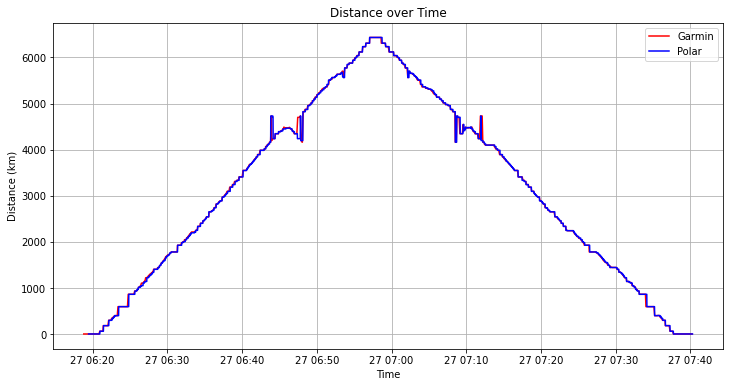

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(garmin_df['time'], garmin_df['route_distance'], color='red', label='Garmin')
plt.plot(polar_df['time'], polar_df['route_distance'], color='blue', label='Polar')
plt.xlabel('Time')
plt.ylabel('Distance (km)')
plt.title('Distance over Time')
plt.legend()
plt.grid(True)
plt.show()